In [2]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from 0 V to 5 V


In [8]:
dut.disconnect()

Serial port disconnected.


In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)

Test with a IV sweep

5.00-

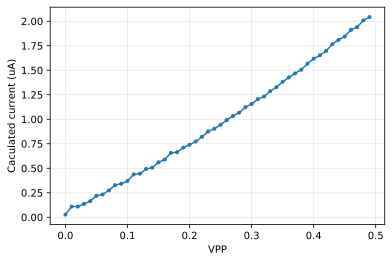

In [17]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=4) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [28]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK', divisor=2)
drv.clk_config('CK_ARRAY', divisor=2)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Batch read domo

Reading array0
Reading array1
Reading array2
0.6956524848937988


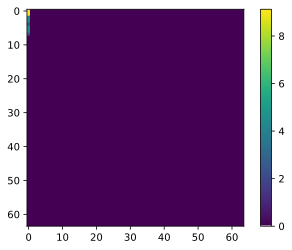

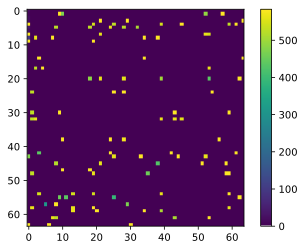

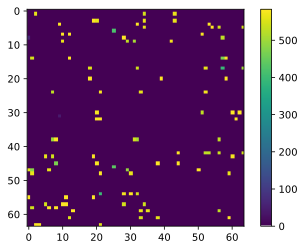

In [29]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

DPE read with unselected rows grounded

DPE: 0-60, len=60
DPE: 60-64, len=4
0.03303241729736328


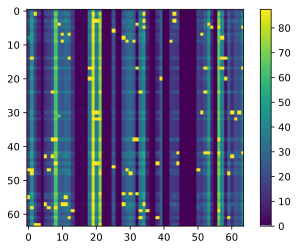

In [30]:
input = [0x1<<i for i in range(64)]
ts = time.time()
data = a0.pic_dpe_batch(2, input, gain=3, Vread=0.2, mode=0) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

DPE read with unselected rows floated

DPE: 0-60, len=60
DPE: 60-64, len=4
0.034034013748168945


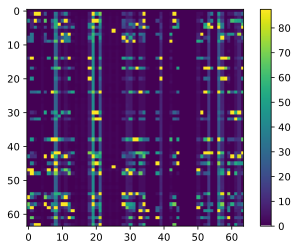

In [31]:
input = [0x1<<i for i in range(64)]

ts = time.time()
data = a0.pic_dpe_batch(2, input, gain=3, Vread=0.2, mode=1) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

Test pic DAC set

In [9]:
drv.ser.write(b'302,' + str(0x9fff).encode() +b',\0')

11

In [29]:
dut.dac_set('P_ADC_EXT_TEST_IN', 0)

00397fff
ff7f3900


In [6]:
dut.dac_init()

DAC initialized to a span from 0 V to 5 V


DPE: 0-60, len=60
DPE: 60-64, len=4
0.04604029655456543


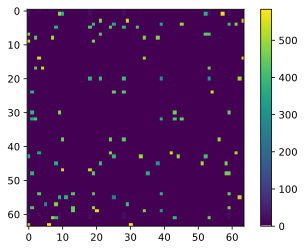

In [15]:
input = [0x1<<i for i in range(64)I]
ts = time.time()
data = a0.pic_dpe_batch(1, input, gain=2, Vread=0.2, mode=1) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

Working on array 1 , device (row= 0 col= 0 )
Initial G= 0.0 Target G = 4e-06
Using Gain= 4 Vread= 0.2 Vread2= 0.15000000000000002


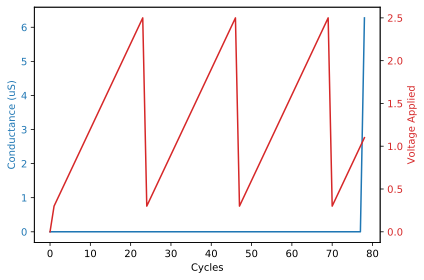

Working on array 1 , device (row= 1 col= 0 )
Initial G= 0.0 Target G = 1.4666666666666666e-05
Using Gain= 4 Vread= 0.1 Vread2= 0.07500000000000001


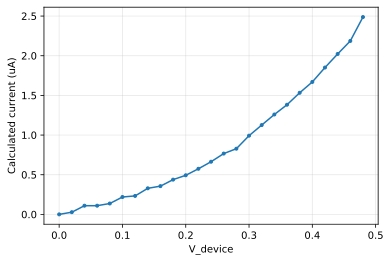

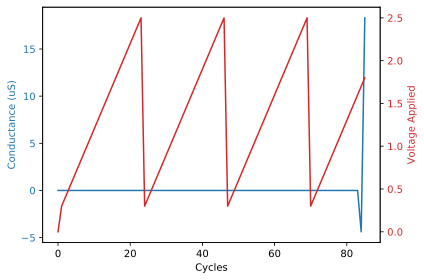

Working on array 1 , device (row= 2 col= 0 )
Initial G= 0.0 Target G = 2.5333333333333334e-05
Using Gain= 4 Vread= 0.05 Vread2= 0.037500000000000006


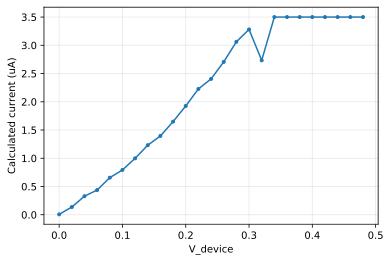

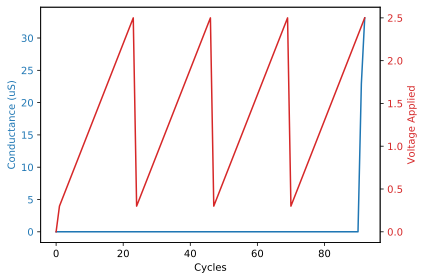

Working on array 1 , device (row= 3 col= 0 )
Initial G= 0.0 Target G = 3.600000000000001e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


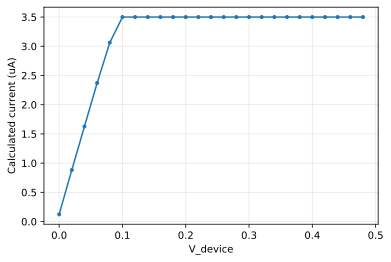

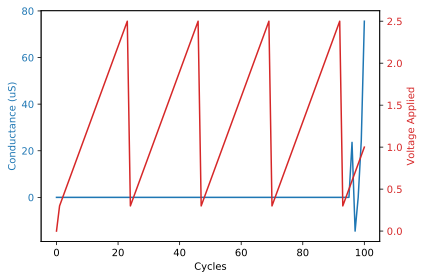

Working on array 1 , device (row= 4 col= 0 )
Initial G= 0.0 Target G = 4.666666666666667e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


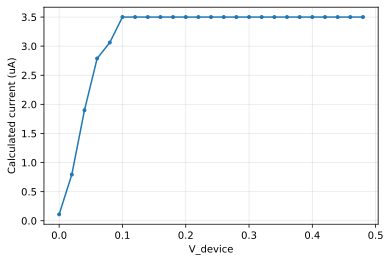

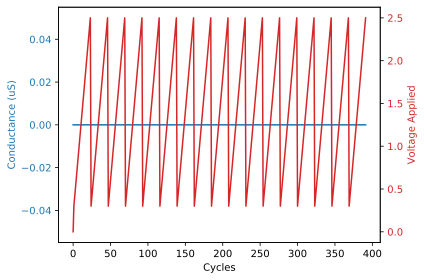

Working on array 1 , device (row= 5 col= 0 )
Initial G= 0.0 Target G = 5.7333333333333336e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


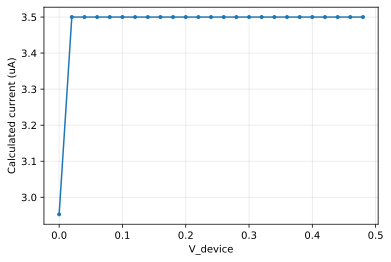

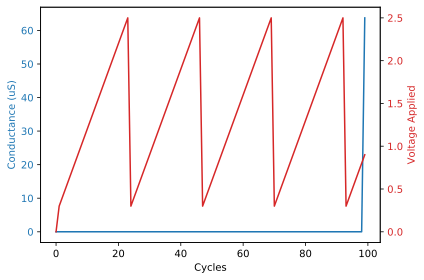

Working on array 1 , device (row= 6 col= 0 )
Initial G= 0.0 Target G = 6.800000000000001e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


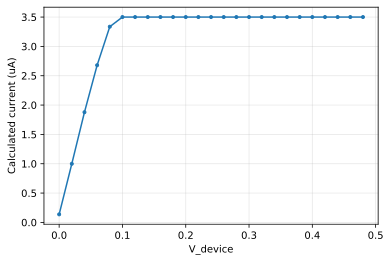

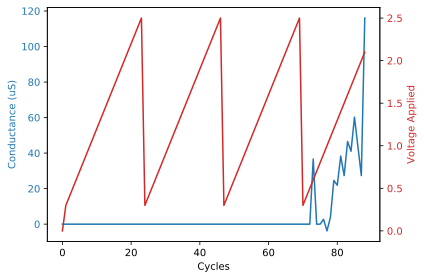

Working on array 1 , device (row= 7 col= 0 )
Initial G= 0.0 Target G = 7.866666666666668e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


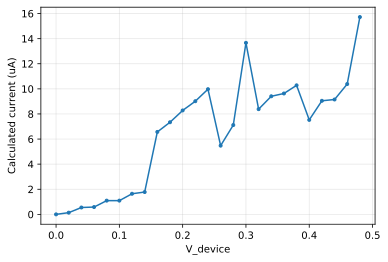

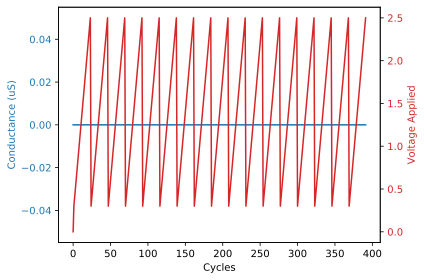

Working on array 1 , device (row= 8 col= 0 )
Initial G= 0.0 Target G = 8.933333333333334e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


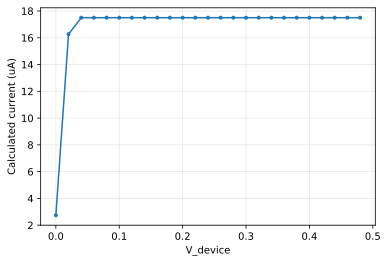

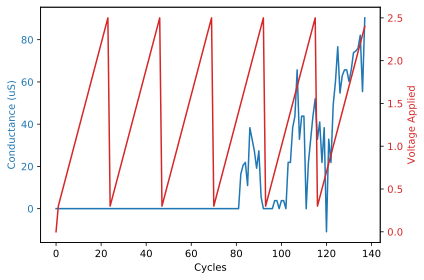

Working on array 1 , device (row= 9 col= 0 )
Initial G= 0.0 Target G = 0.0001
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


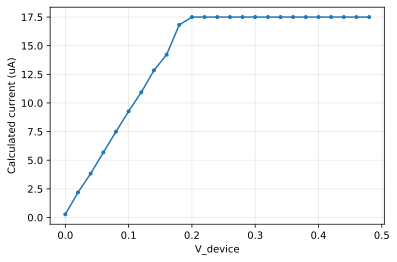

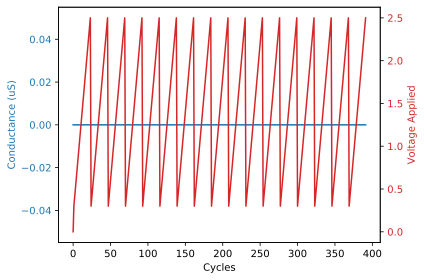

GHistory= [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.275659824046924e-06], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.3792766373411565e-06, 1.8299120234604112e-05], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

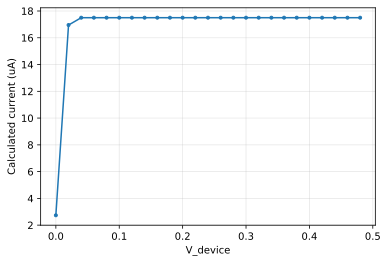

In [17]:
gainRes = np.array([1e3, 5e3, 3e4, 2e5, 1e6])
maxGainCurr = 3.5*0.85/gainRes
VreadGate = 5.0

maxGRange = np.array([1e-6, 8e-6, 16e-6, 32e-6, 64e-6, 100e-6, 165e-6, 300e-6, 500e-6])
gainChoice = np.array([4, 4, 4, 4, 4, 3, 3, 3])
minCurrentExp = np.array([1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
readV = np.array([0.4, 0.2, 0.1, 0.05, 0.03, 0.1, 0.05, 0.03])
readV2 = 0.75*readV

arr = 1
startRow = 0
startCol = 0
numRows = 10
numCols = 1
GMin = 4e-6
GMax = 100e-6

targetGVals = np.linspace(GMin, GMax, numRows)
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

#gainForTargetG = 4-np.searchsorted(np.flip(maxGainCurr),targetGVals)
targetGIndexSetting = np.searchsorted(maxGRange,targetGVals)

vAppliedSet = np.arange(0.3, 2.6, 0.1)
vAppliedReset = np.arange(0.3, 2.6, 0.1)
vGateSet = np.arange(0.5, 2.2, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)
GHistory = []
VHistory = []
for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i]
        #thisGain = gainForTargetG[i]
        thisGain = gainChoice[targetGIndexSetting[i]]
        thisReadV = readV[targetGIndexSetting[i]]
        thisReadV2 = readV2[targetGIndexSetting[i]]
        minCurrExp = minCurrentExp[targetGIndexSetting[i]]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
        currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
        currG = (currI1-currI2)/(thisReadV-thisReadV2)
        thisGHistory.append(currG)
        thisVHistory.append(0)
        print('Initial G=', currG, 'Target G =', thisGtarget)
        print('Using Gain=', thisGain, 'Vread=', thisReadV, 'Vread2=', thisReadV2)        
        # Now, if device is lower than target, SET it
        if currG < thisGtarget:
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)
                    currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    #currI1 = a0.read_single_int(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    #currI2 = a0.read_single_int(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    currG = (currI1-currI2)/(thisReadV-thisReadV2)
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= thisGtarget:
                        break
                if currG >= thisGtarget:
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it
        elif currG > thisGtarget:
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                    currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    #currI1 = a0.read_single_int(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    #currI2 = a0.read_single_int(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    currG = (currI1-currI2)/(thisReadV-thisReadV2)                    
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= thisGtarget:
                        break
                if currG <= thisGtarget:
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        # we already handled the x-label with ax1
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        
        Vreads = np.arange(0, 0.5, 0.02)
        Vggate = 5
        volts = []
        for vread in Vreads:
            volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
        plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

        plt.xlabel('V_device')
        plt.ylabel('Calculated current (uA)')
        plt.grid(True, alpha=0.3)

    print('GHistory=', GHistory)
    print('VHistory=', VHistory)

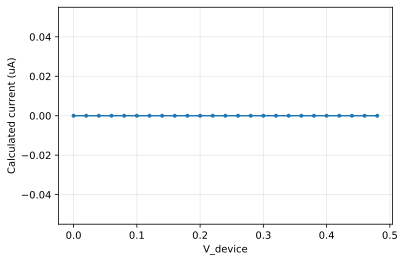

In [27]:
arr = 0
rr = 4
cc = 20
thisGain = 2
Vreads = np.arange(0, 0.5, 0.02)
Vggate = 5
volts = []
for vread in Vreads:
    volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

Reading array0
Reading array1
Reading array2
2.1560299396514893


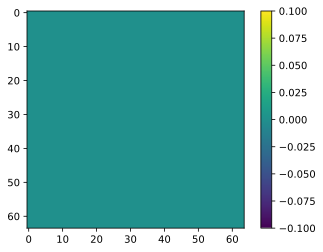

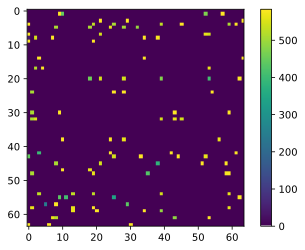

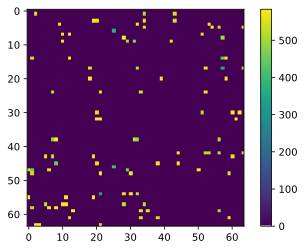

In [20]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

Reading array0
Reading array1
Reading array2
2.16401743888855


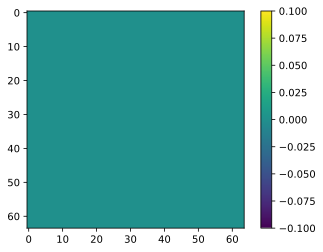

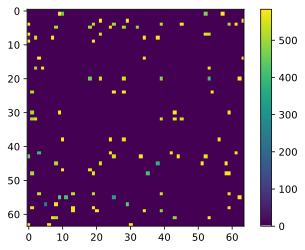

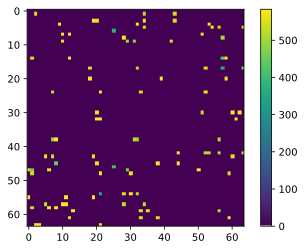

In [28]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

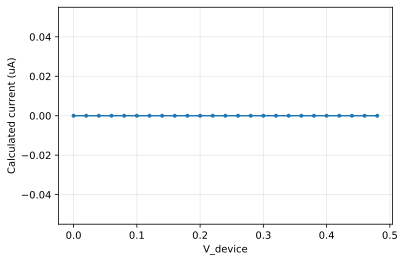

In [5]:
arr = 2
rr = 4
cc = 20
thisGain = 4
Vreads = np.arange(0, 0.5, 0.02)
Vggate = 5
volts = []
for vread in Vreads:
    volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)